In [1]:
import argparse
import cv2
import os
from os.path import exists,join, split, dirname
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import sys 
sys.path.append('../')
from PIL import Image
import torch 
import torch.utils.data
from torch import nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from segment import SegList

import dla_up 
import data_transforms as transforms
import dataset

try:
    from modules import batchnormsync
    HAS_BN_SYNC = True 
except ImportError:
    HAS_BN_SYNC = True 
    
torch.set_default_tensor_type('torch.cuda.FloatTensor')

%matplotlib inline

In [2]:
# import pytorch model 
# model = torch.load('../model_best.pth.tar')
model = torch.load('../checkpoint_1200.pth.tar')
# model = torch.load('/media/sastrygrp2/Backup/dla/boundary_data/unhidden/w_layout/model_best.pth.tar')

In [3]:
phase = 'val'
data_dir = '/media/sastrygrp2/Backup/boundary_data/unhidden/'
# data_dir = 'C:/Users/biosim/oladapo/data/Cityscape/'
t = []

info = dataset.load_dataset_info(data_dir)
normalize = transforms.Normalize(mean=info.mean, std=info.std)
# scales = [0.5, 0.75, 1.25, 1.5, 1.75]
scales = [0.5, 0.75, 1.25, 1.5]
t = []
crop_size = 416
# if args.crop_size > 0:
t.append(transforms.RandomCrop(crop_size))
# t.append(transforms.PadToSize(crop_size))
t.extend([transforms.ToTensor(), normalize])

data = SegList(data_dir, phase, transforms.Compose(t),
                       out_name=True, out_size=True,
                       binary= True)
test_loader = torch.utils.data.DataLoader(data,
batch_size=1, shuffle=False, num_workers=1,
pin_memory=False
)

In [ ]:
# j = 0
# for iter, (im, label, name, size) in enumerate(test_loader):
#     j = j+1
    
    
# #     tmp = np.reshape(tmp,(crop_size,crop_size, 3))
# #     plt.imshow(np.squeeze(im[0,:,:,:]))
#     plt.imshow(tmp)
#     plt.show()
    
#     if j > 0:
#         break

/home/sastrygrp2/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
[2018-11-08 14:46:14,980 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/520.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/520.png
(4, 416, 416)
(416, 416, 4)


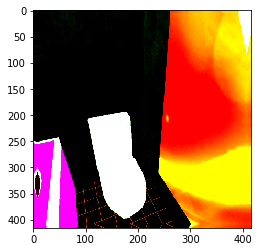

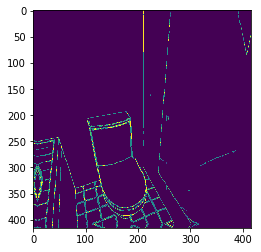

1


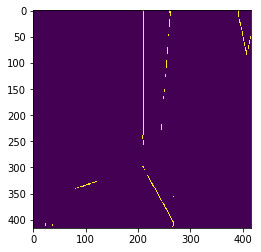

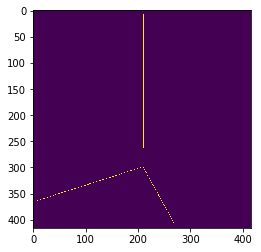

Press Enter to continue...


[2018-11-08 14:46:27,378 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/4307.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4307.png
(4, 416, 416)
(416, 416, 4)


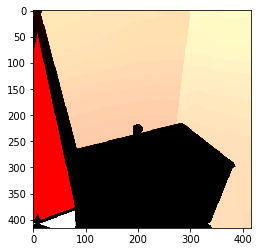

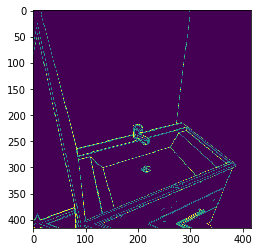

1


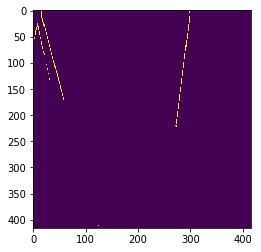

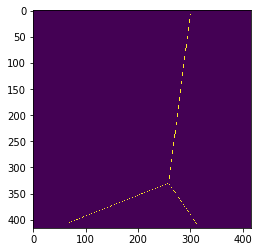

Press Enter to continue...


[2018-11-08 14:46:35,497 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/5196.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5196.png
(4, 416, 416)
(416, 416, 4)


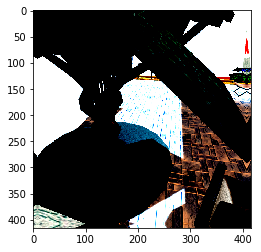

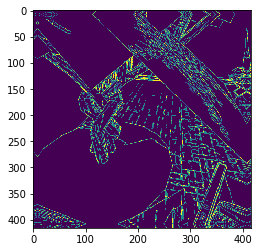

1


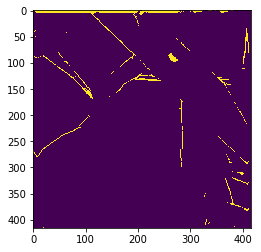

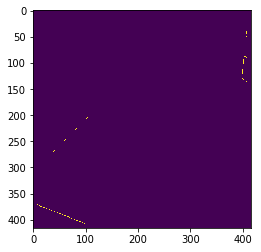

Press Enter to continue...


[2018-11-08 14:46:39,689 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/4439.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4439.png
(4, 416, 416)
(416, 416, 4)


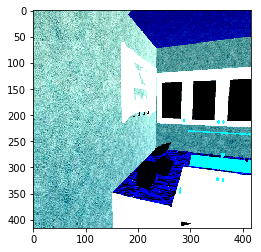

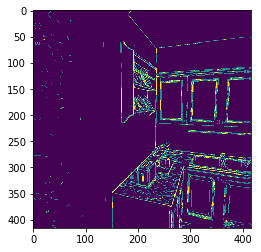

1


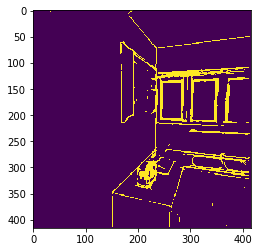

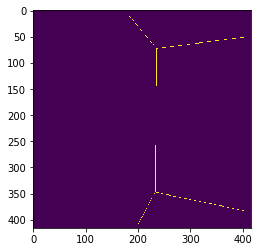

Press Enter to continue...


[2018-11-08 14:46:45,897 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/5076.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5076.png
(4, 416, 416)
(416, 416, 4)


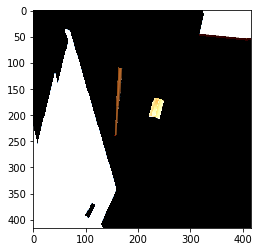

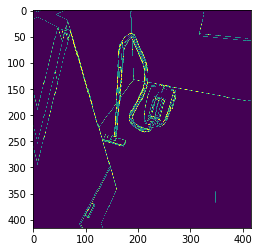

1


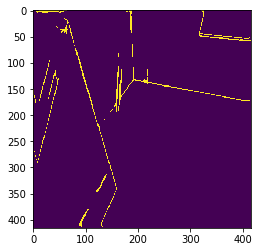

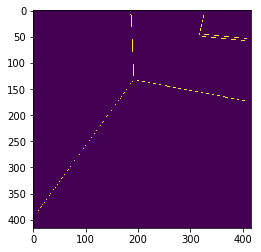

Press Enter to continue...


[2018-11-08 14:46:56,377 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/5457.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5457.png
(4, 416, 416)
(416, 416, 4)


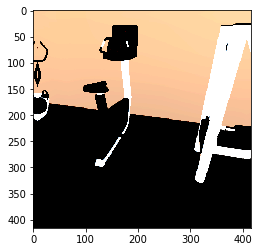

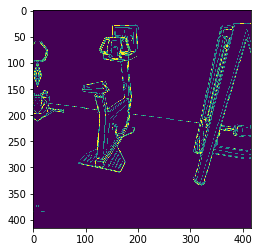

1


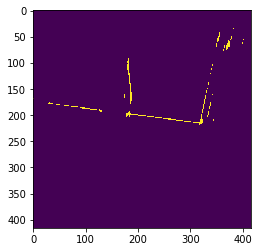

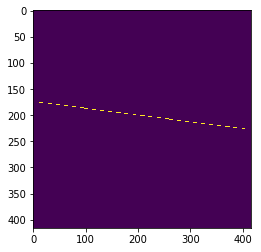

Press Enter to continue...


[2018-11-08 14:47:03,327 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/753.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/753.png
(4, 416, 416)
(416, 416, 4)


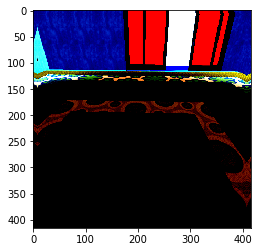

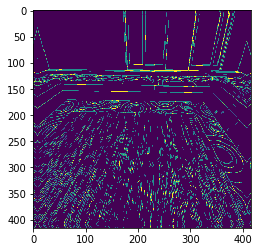

1


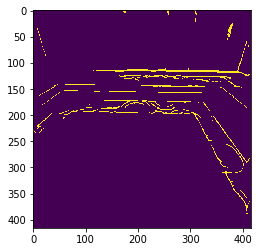

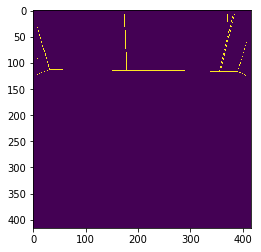

Press Enter to continue...


[2018-11-08 14:47:08,332 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/1085.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/1085.png
(4, 416, 416)
(416, 416, 4)


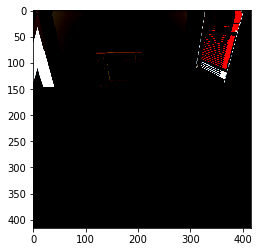

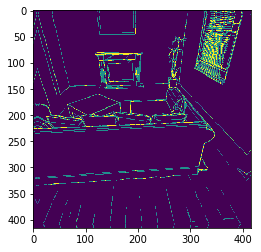

1


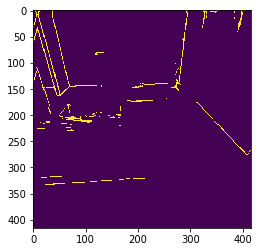

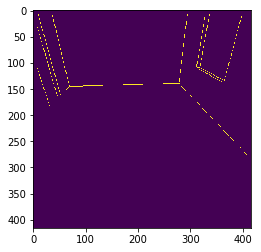

Press Enter to continue...


[2018-11-08 14:47:17,560 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/4150.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4150.png
(4, 416, 416)
(416, 416, 4)


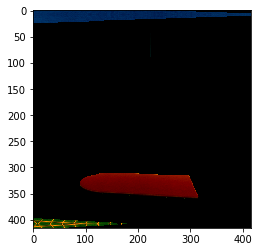

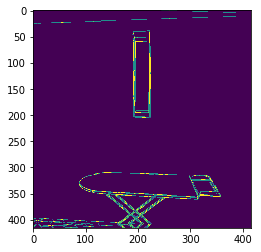

1


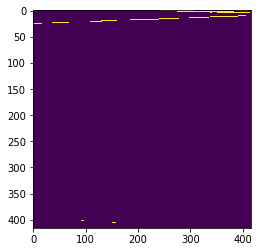

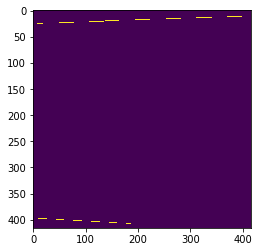

Press Enter to continue...


[2018-11-08 14:47:21,536 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/4172.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4172.png
(4, 416, 416)
(416, 416, 4)


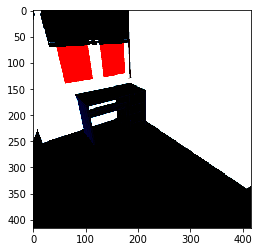

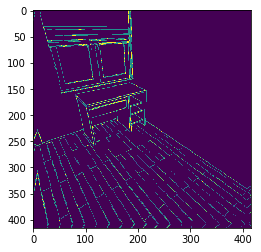

1


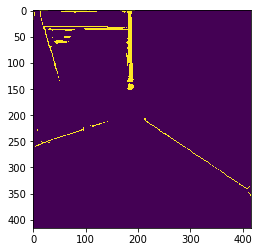

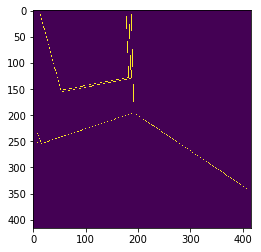

Press Enter to continue...


[2018-11-08 14:47:28,144 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/1870.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/1870.png
(4, 416, 416)
(416, 416, 4)


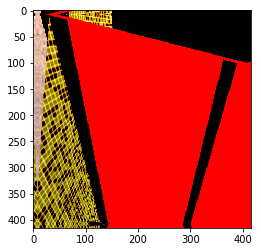

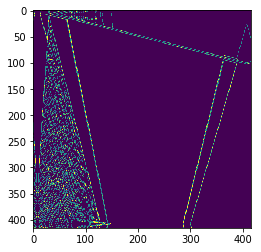

1


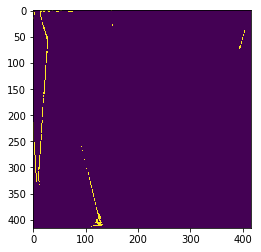

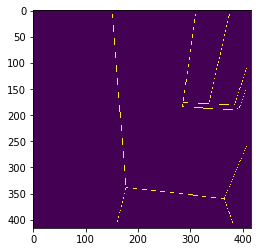

Press Enter to continue...


[2018-11-08 14:47:33,919 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/5266.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5266.png
(4, 416, 416)
(416, 416, 4)


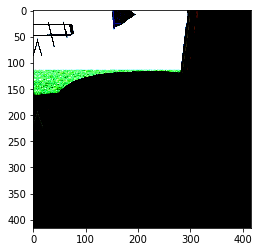

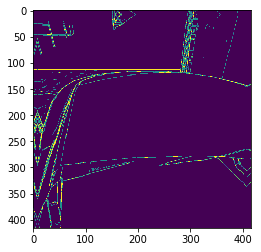

1


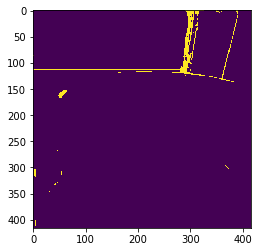

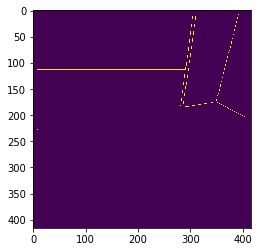

Press Enter to continue...


[2018-11-08 14:47:38,904 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/698.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/698.png
(4, 416, 416)
(416, 416, 4)


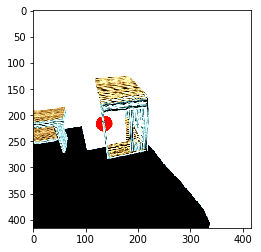

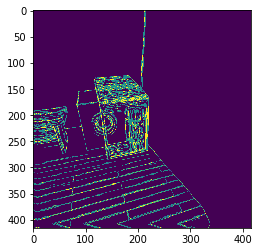

1


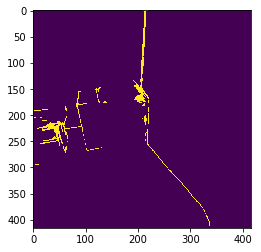

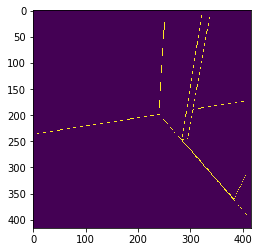

Press Enter to continue...


[2018-11-08 14:47:43,718 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/5318.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5318.png
(4, 416, 416)
(416, 416, 4)


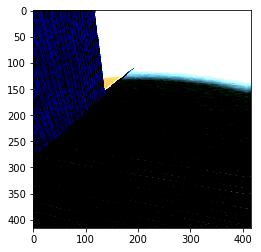

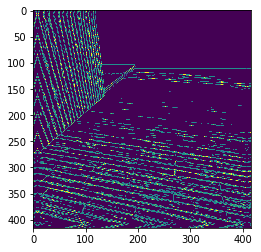

1


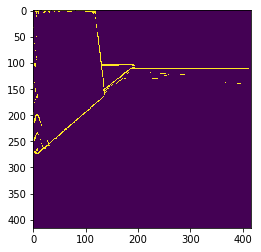

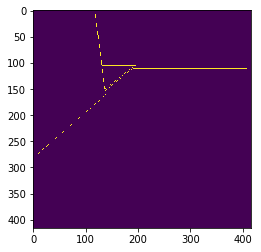

Press Enter to continue...


[2018-11-08 14:47:52,923 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/3755.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/3755.png
(4, 416, 416)
(416, 416, 4)


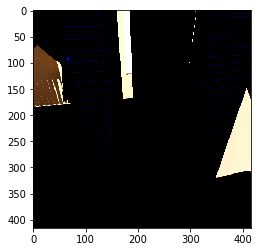

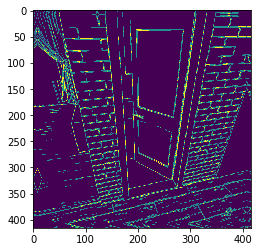

1


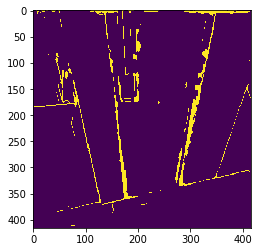

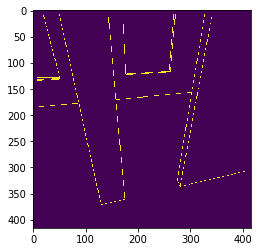

Press Enter to continue...


[2018-11-08 14:48:10,719 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/1773.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/1773.png
(4, 416, 416)
(416, 416, 4)


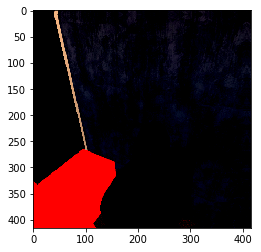

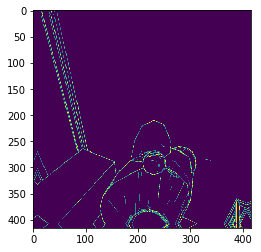

1


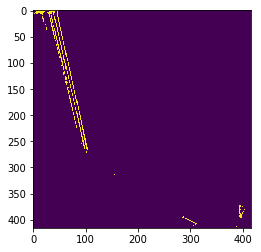

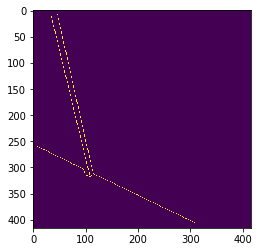

Press Enter to continue...


[2018-11-08 14:48:19,379 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/148.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/148.png
(4, 416, 416)
(416, 416, 4)


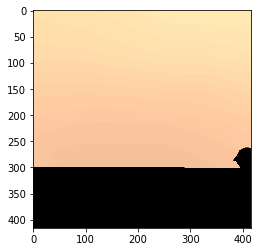

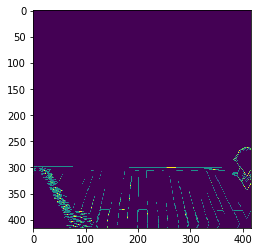

1


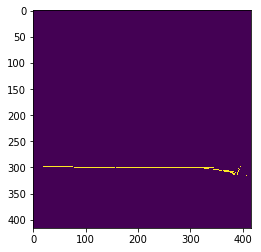

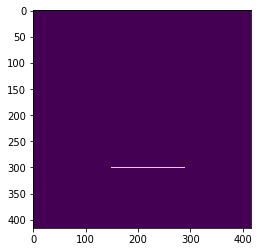

Press Enter to continue...


[2018-11-08 14:48:27,920 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/660.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/660.png
(4, 416, 416)
(416, 416, 4)


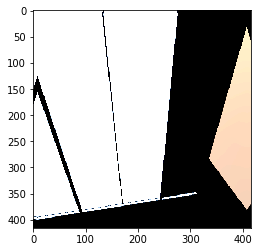

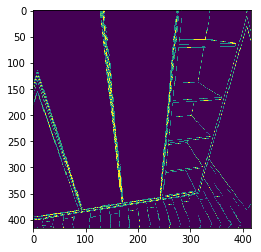

1


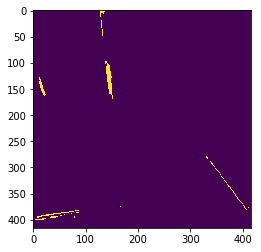

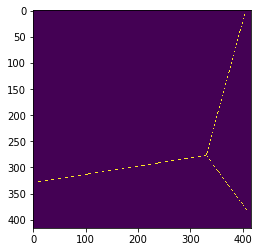

Press Enter to continue...


[2018-11-08 14:48:32,660 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/3954.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/3954.png
(4, 416, 416)
(416, 416, 4)


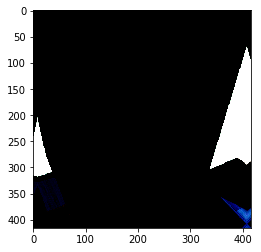

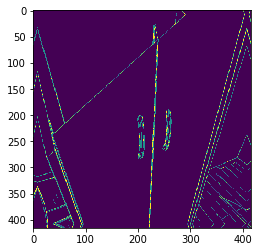

1


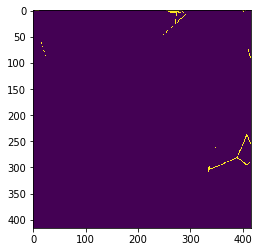

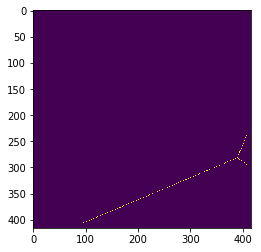

Press Enter to continue...


[2018-11-08 14:48:38,739 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/239.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/239.png
(4, 416, 416)
(416, 416, 4)


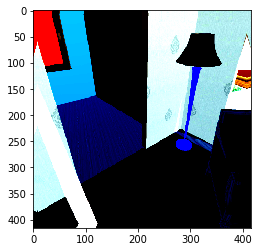

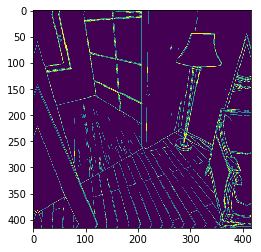

1


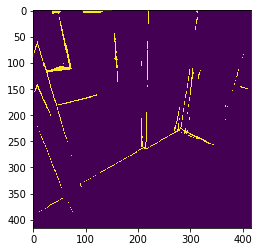

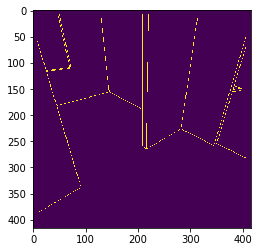

Press Enter to continue...


[2018-11-08 14:48:46,896 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/5509.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5509.png
(4, 416, 416)
(416, 416, 4)


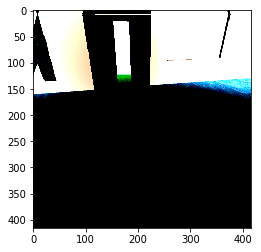

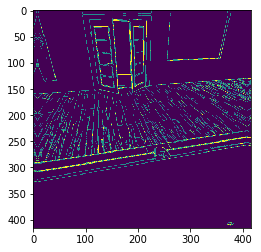

1


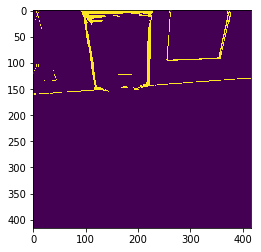

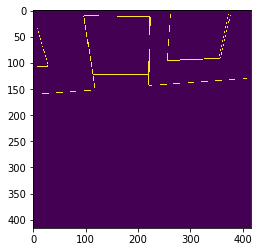

Press Enter to continue...


[2018-11-08 14:48:50,375 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/898.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/898.png
(4, 416, 416)
(416, 416, 4)


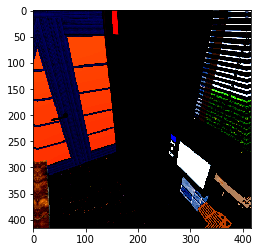

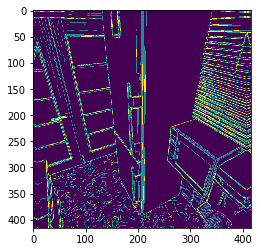

1


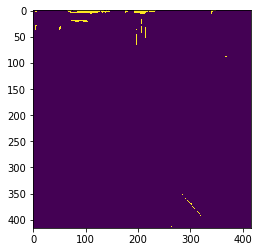

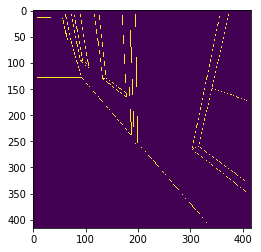

Press Enter to continue...


[2018-11-08 14:48:54,427 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/938.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/938.png
(4, 416, 416)
(416, 416, 4)


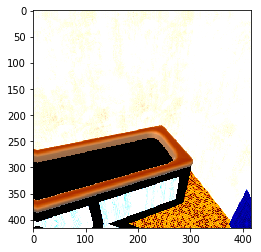

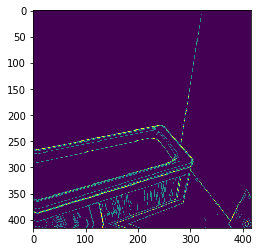

1


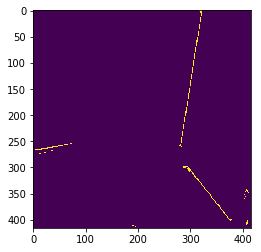

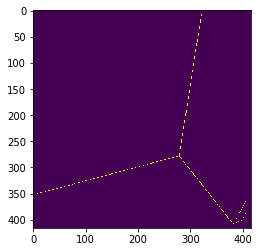

Press Enter to continue...


[2018-11-08 14:49:00,327 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/404.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/404.png
(4, 416, 416)
(416, 416, 4)


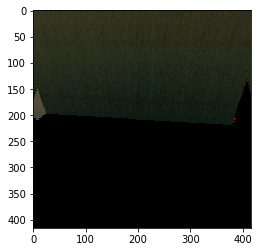

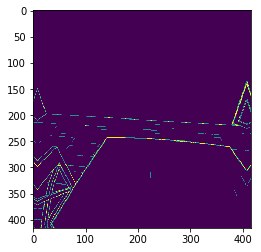

1


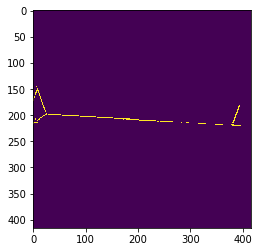

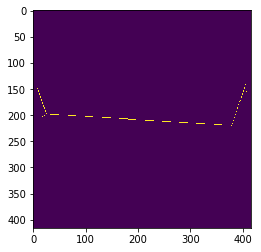

Press Enter to continue...


[2018-11-08 14:49:08,931 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/5231.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5231.png
(4, 416, 416)
(416, 416, 4)


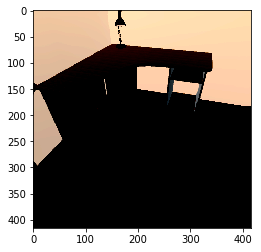

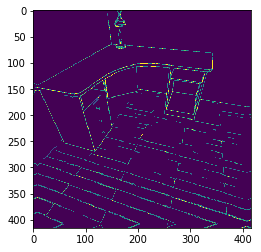

1


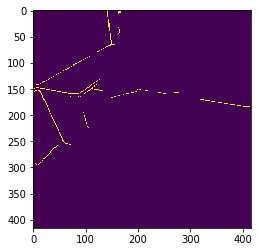

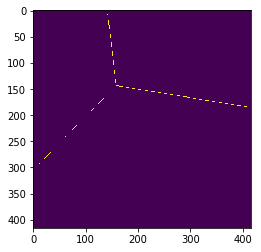

Press Enter to continue...


[2018-11-08 14:49:24,914 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/1388.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/1388.png
(4, 416, 416)
(416, 416, 4)


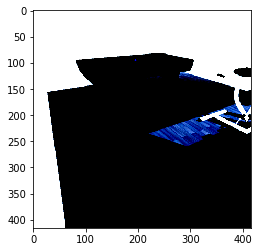

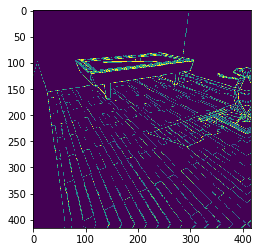

1


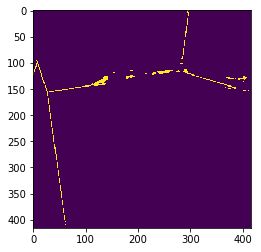

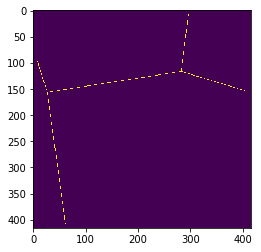

Press Enter to continue...


[2018-11-08 14:49:31,135 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/4865.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4865.png
(4, 416, 416)
(416, 416, 4)


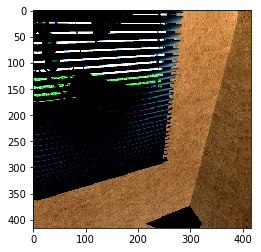

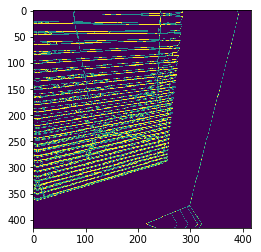

1


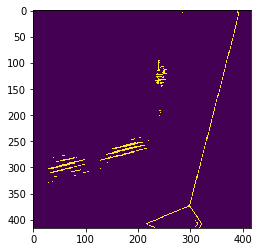

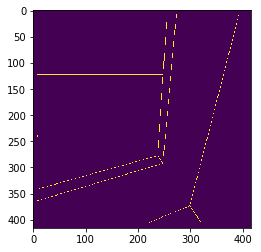

Press Enter to continue...


[2018-11-08 14:49:36,987 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/1900.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/1900.png
(4, 416, 416)
(416, 416, 4)


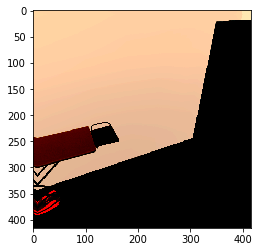

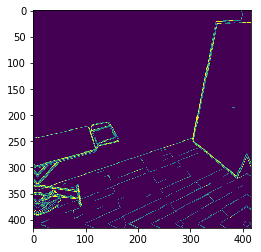

1


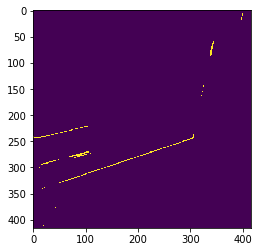

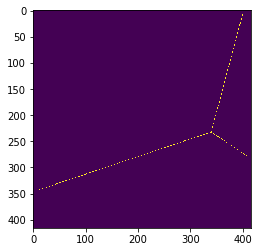

Press Enter to continue...


[2018-11-08 14:49:42,700 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/4814.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4814.png
(4, 416, 416)
(416, 416, 4)


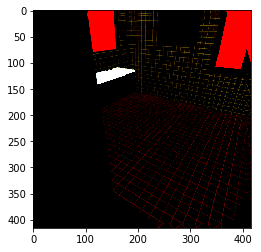

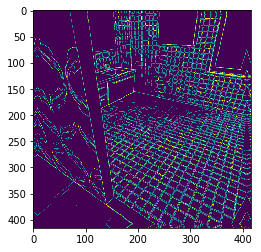

1


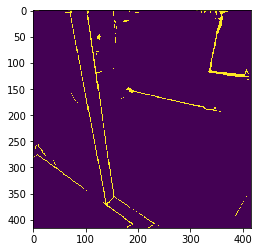

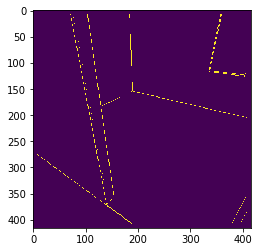

Press Enter to continue...


[2018-11-08 14:49:48,924 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/4879.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4879.png
(4, 416, 416)
(416, 416, 4)


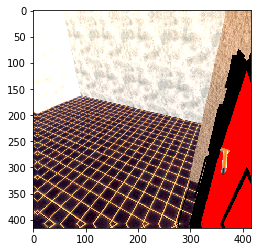

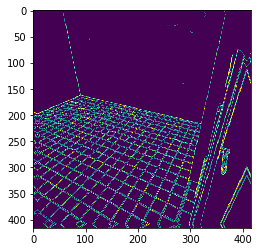

1


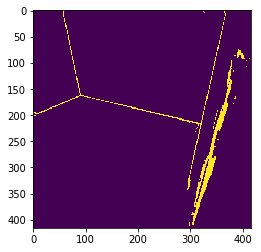

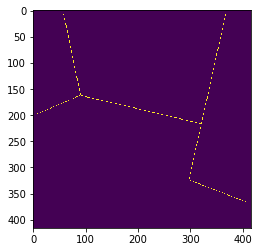

Press Enter to continue...


[2018-11-08 14:49:57,819 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/139.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/139.png
(4, 416, 416)
(416, 416, 4)


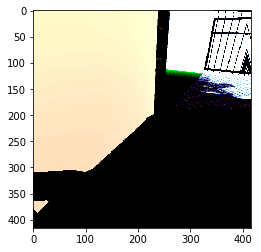

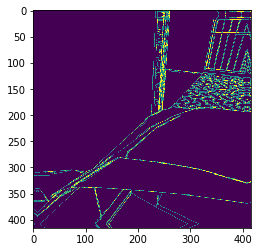

1


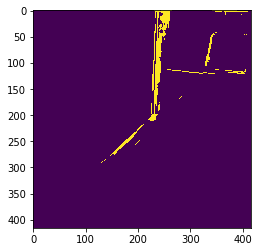

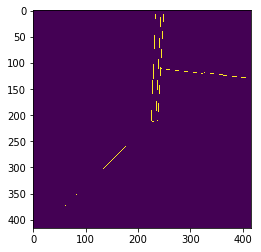

Press Enter to continue...


[2018-11-08 14:50:02,266 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/3535.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/3535.png
(4, 416, 416)
(416, 416, 4)


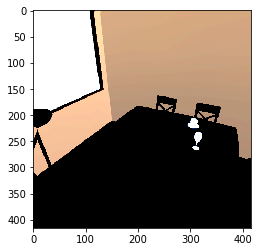

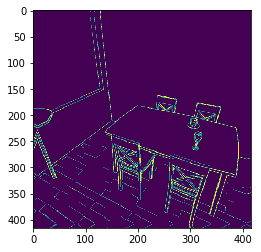

1


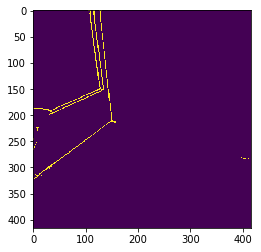

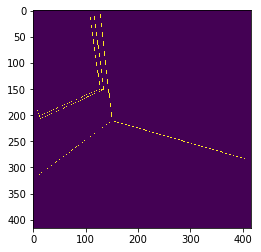

Press Enter to continue...


[2018-11-08 14:50:06,187 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/5082.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5082.png
(4, 416, 416)
(416, 416, 4)


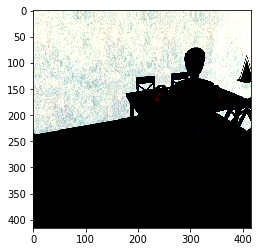

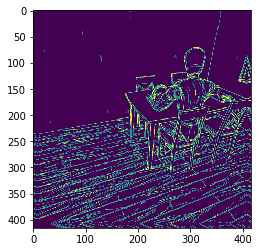

1


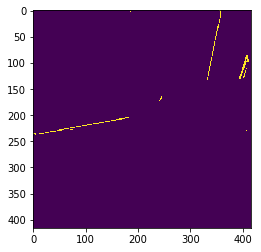

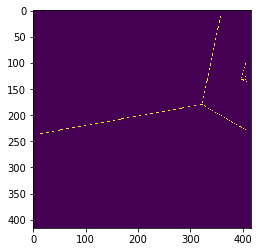

Press Enter to continue...


[2018-11-08 14:50:10,735 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/3680.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/3680.png
(4, 416, 416)
(416, 416, 4)


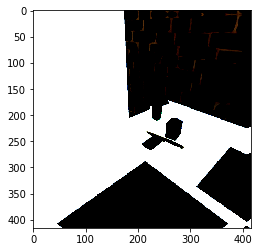

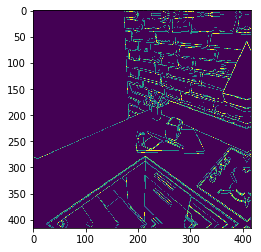

1


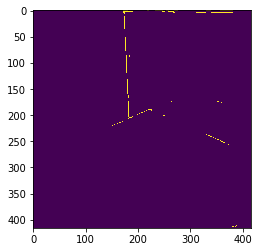

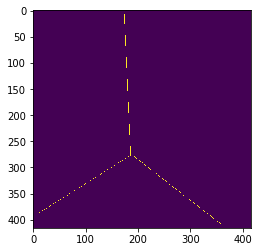

Press Enter to continue...


[2018-11-08 14:50:15,296 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/1939.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/1939.png
(4, 416, 416)
(416, 416, 4)


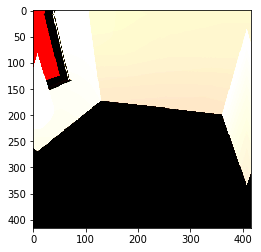

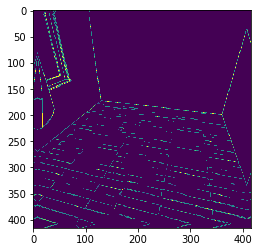

1


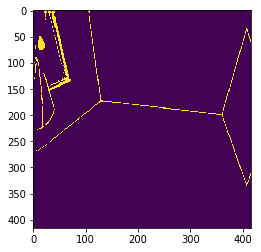

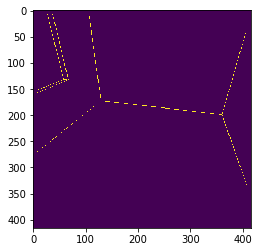

Press Enter to continue...


[2018-11-08 14:50:31,460 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/3883.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/3883.png
(4, 416, 416)
(416, 416, 4)


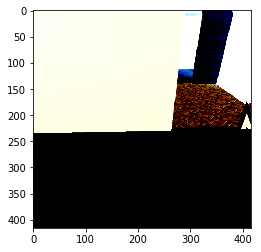

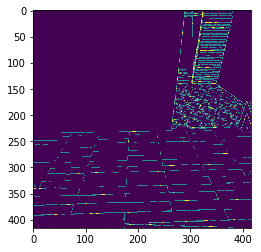

1


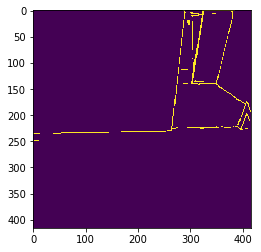

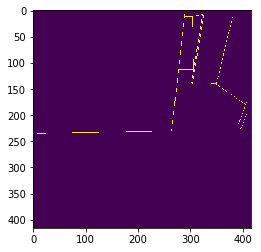

Press Enter to continue...


[2018-11-08 14:50:35,111 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/5462.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5462.png
(4, 416, 416)
(416, 416, 4)


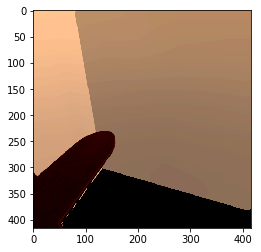

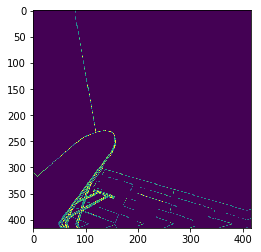

1


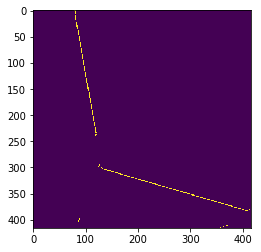

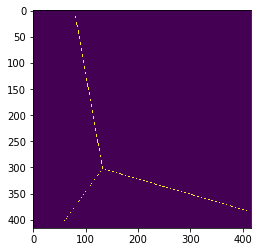

Press Enter to continue...


[2018-11-08 14:50:44,605 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/1509.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/1509.png
(4, 416, 416)
(416, 416, 4)


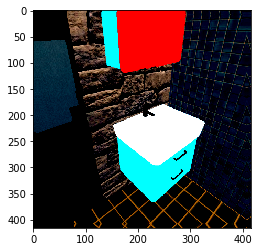

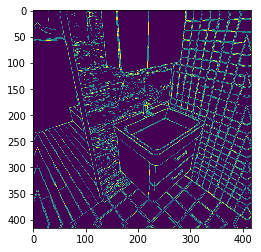

1


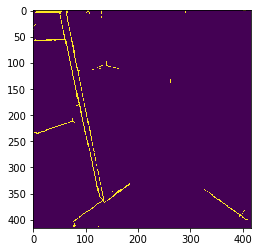

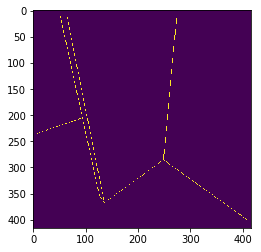

Press Enter to continue...
('RGB/5257.png',)


[2018-11-08 14:51:04,299 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5257.png
(4, 416, 416)
(416, 416, 4)


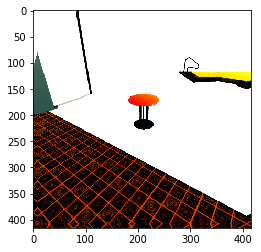

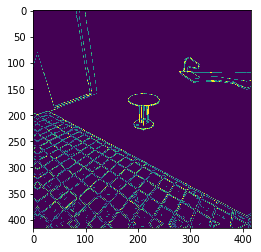

1


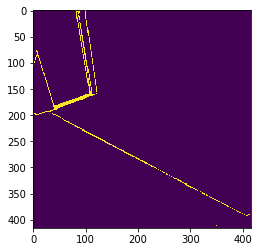

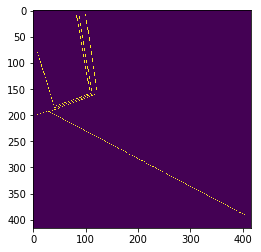

Press Enter to continue...
('RGB/1874.png',)


[2018-11-08 14:51:16,549 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/1874.png
(4, 416, 416)
(416, 416, 4)


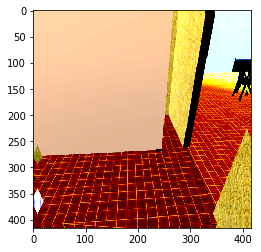

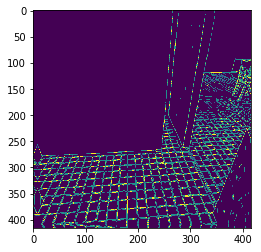

1


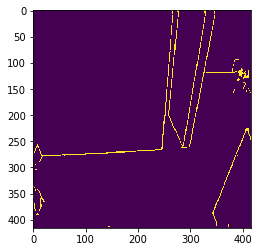

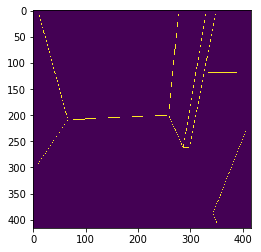

Press Enter to continue...
('RGB/3598.png',)


[2018-11-08 14:51:26,149 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/3598.png
(4, 416, 416)
(416, 416, 4)


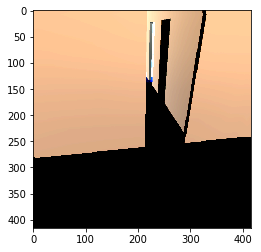

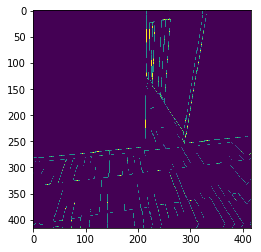

1


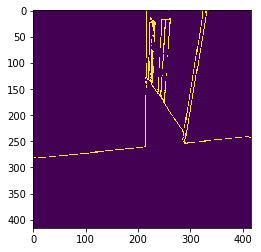

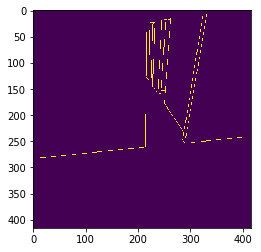

Press Enter to continue...


[2018-11-08 14:51:31,159 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/3937.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/3937.png
(4, 416, 416)
(416, 416, 4)


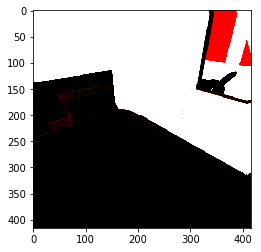

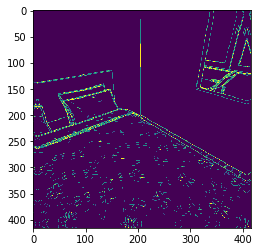

1


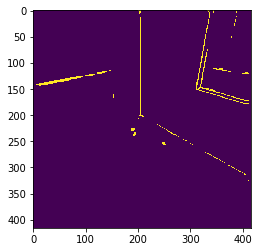

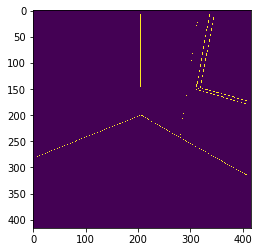

Press Enter to continue...


[2018-11-08 14:51:34,662 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/5454.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5454.png
(4, 416, 416)
(416, 416, 4)


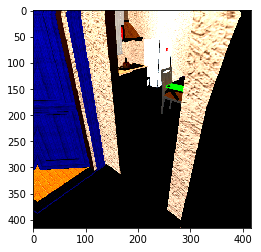

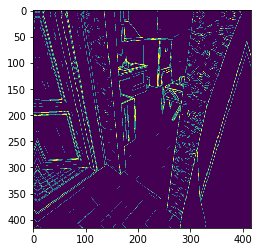

1


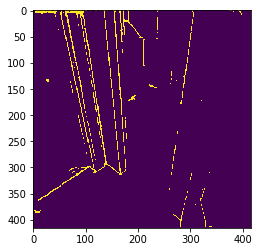

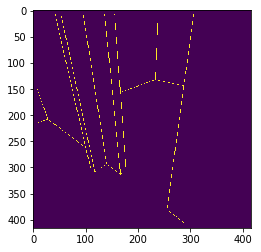

Press Enter to continue...


[2018-11-08 14:51:41,080 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/5442.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5442.png
(4, 416, 416)
(416, 416, 4)


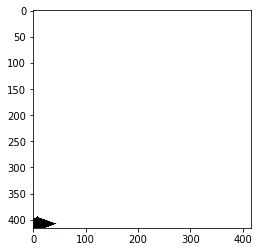

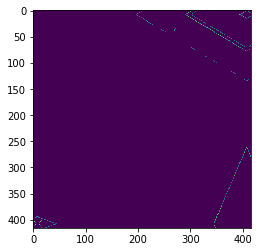

1


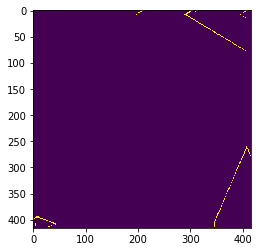

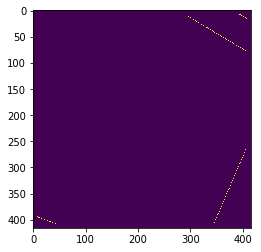

Press Enter to continue...


[2018-11-08 14:51:44,581 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/4183.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4183.png
(4, 416, 416)
(416, 416, 4)


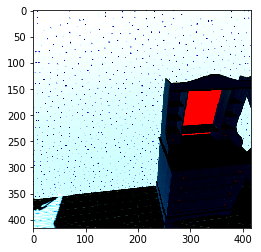

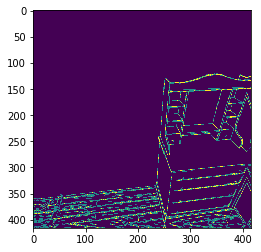

1


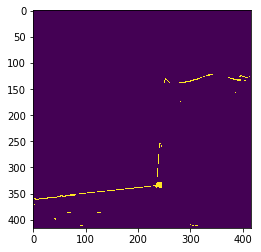

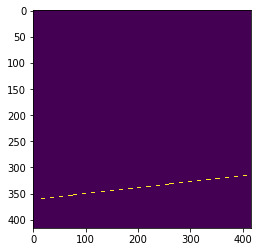

Press Enter to continue...


[2018-11-08 14:51:50,380 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/5326.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5326.png
(4, 416, 416)
(416, 416, 4)


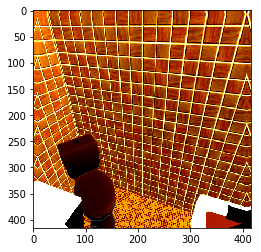

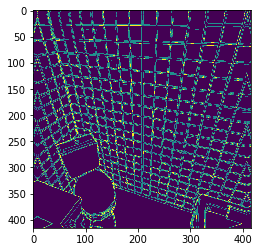

1


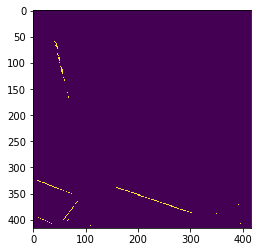

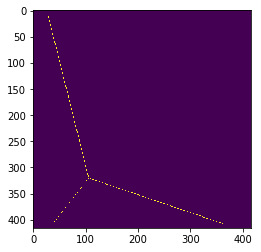

Press Enter to continue...


[2018-11-08 14:51:54,382 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/3982.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/3982.png
(4, 416, 416)
(416, 416, 4)


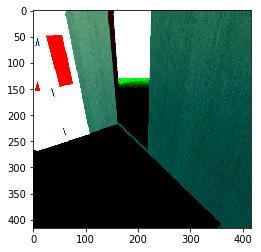

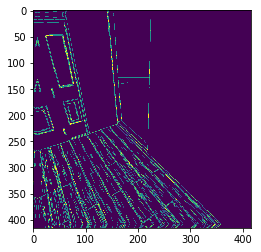

1


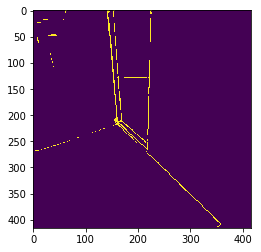

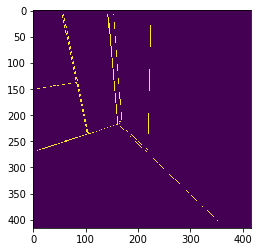

Press Enter to continue...


[2018-11-08 14:51:58,052 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/5038.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5038.png
(4, 416, 416)
(416, 416, 4)


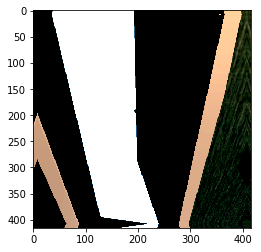

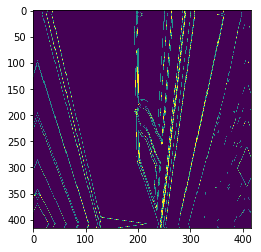

1


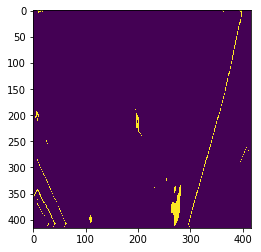

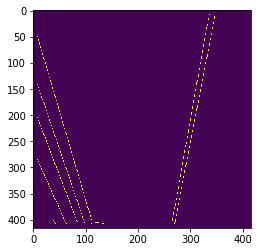

Press Enter to continue...


[2018-11-08 14:52:01,447 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/5465.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5465.png
(4, 416, 416)
(416, 416, 4)


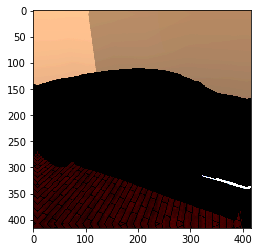

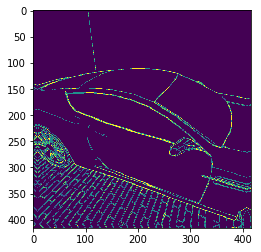

1


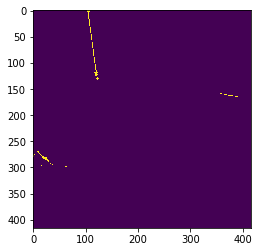

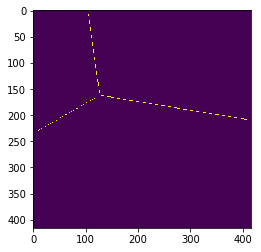

Press Enter to continue...
('RGB/420.png',)


[2018-11-08 14:52:10,522 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/420.png
(4, 416, 416)
(416, 416, 4)


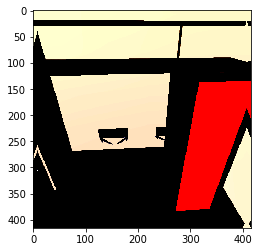

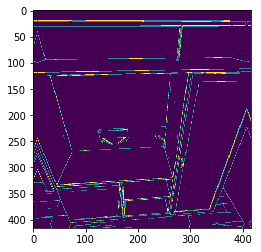

1


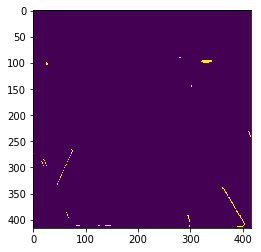

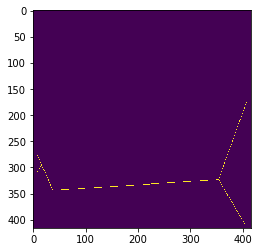

Press Enter to continue...


[2018-11-08 14:52:13,851 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/4759.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4759.png
(4, 416, 416)
(416, 416, 4)


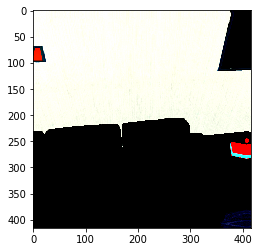

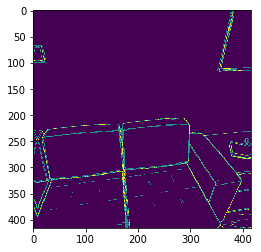

1


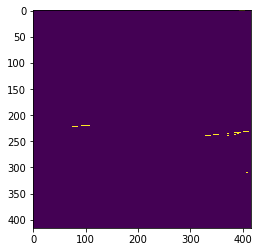

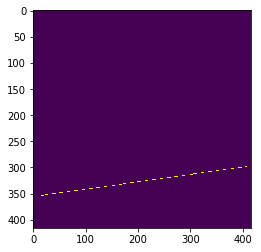

Press Enter to continue...
('RGB/4158.png',)


[2018-11-08 14:52:27,147 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4158.png
(4, 416, 416)
(416, 416, 4)


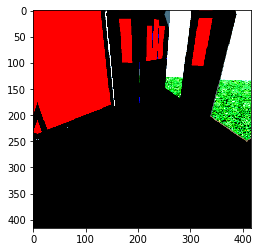

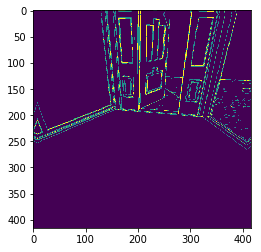

1


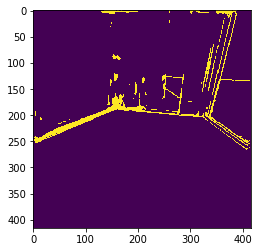

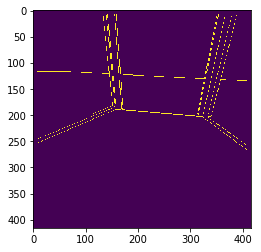

Press Enter to continue...


[2018-11-08 14:52:33,355 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/385.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/385.png
(4, 416, 416)
(416, 416, 4)


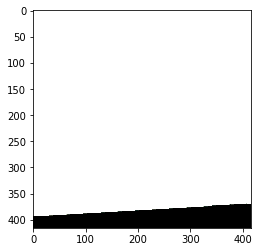

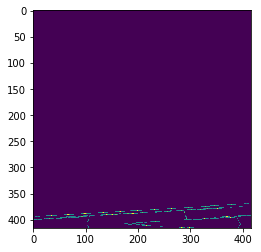

1


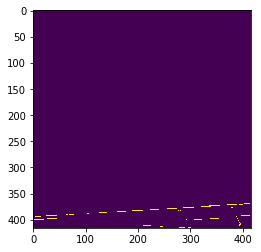

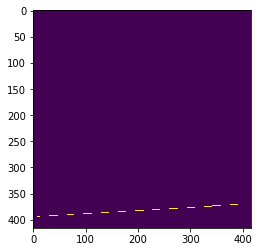

Press Enter to continue...


[2018-11-08 14:52:38,891 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/4785.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4785.png
(4, 416, 416)
(416, 416, 4)


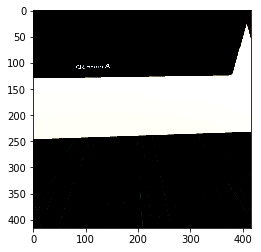

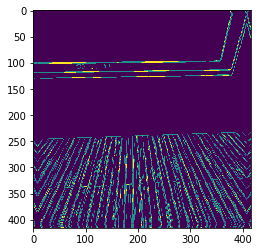

1


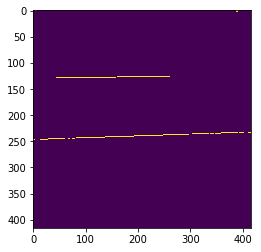

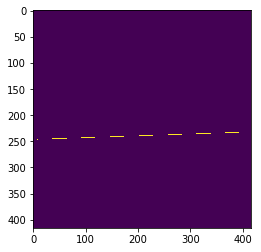

Press Enter to continue...


[2018-11-08 14:52:44,715 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/4232.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4232.png
(4, 416, 416)
(416, 416, 4)


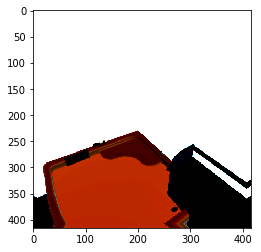

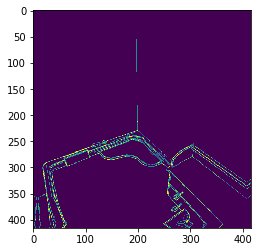

1


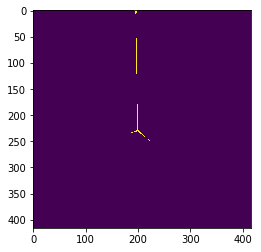

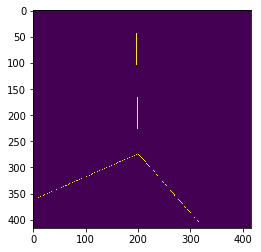

Press Enter to continue...
('RGB/4959.png',)


[2018-11-08 14:52:55,144 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4959.png
(4, 416, 416)
(416, 416, 4)


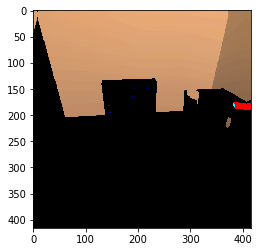

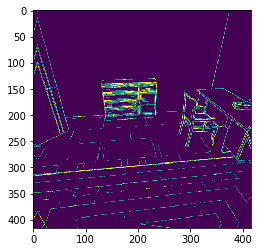

1


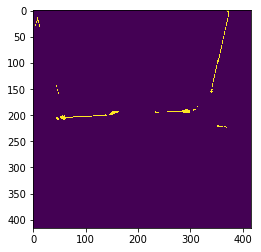

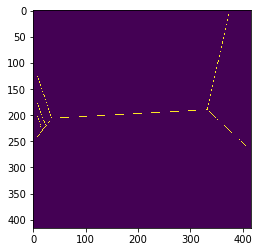

Press Enter to continue...
('RGB/4917.png',)


[2018-11-08 14:53:04,252 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4917.png
(4, 416, 416)
(416, 416, 4)


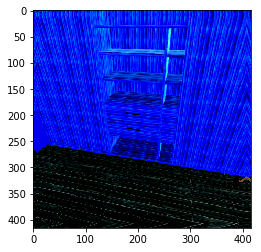

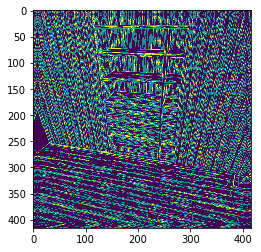

1


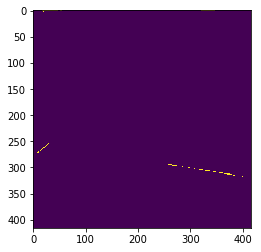

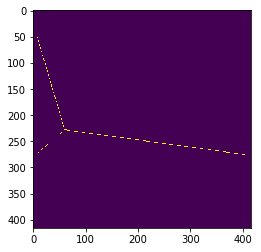

Press Enter to continue...


[2018-11-08 14:53:10,361 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/5307.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/5307.png
(4, 416, 416)
(416, 416, 4)


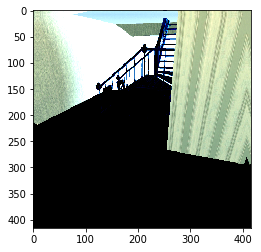

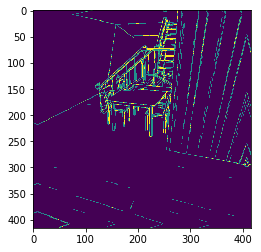

1


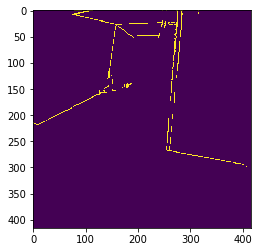

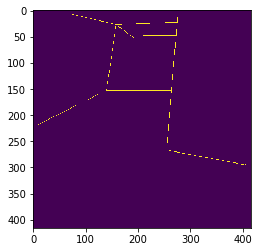

Press Enter to continue...


[2018-11-08 14:53:14,443 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/4260.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4260.png
(4, 416, 416)
(416, 416, 4)


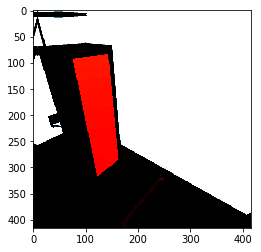

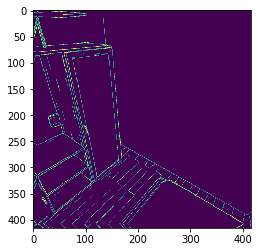

1


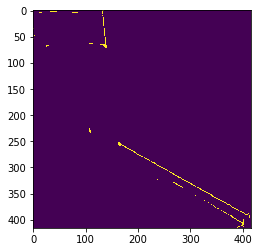

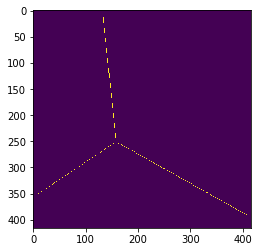

Press Enter to continue...


[2018-11-08 14:53:20,557 image.py:664 set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('RGB/4100.png',)
/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/4100.png
(4, 416, 416)
(416, 416, 4)


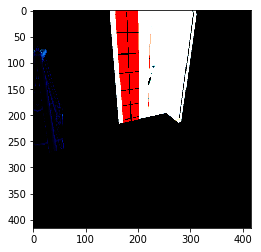

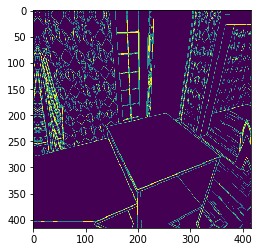

1


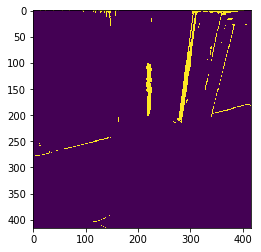

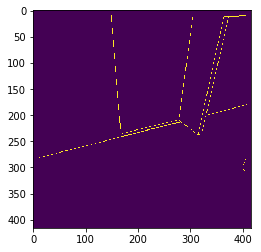

Press Enter to continue...q


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4d0d73cfd0>>
Traceback (most recent call last):
  File "/home/sastrygrp2/anaconda2/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/sastrygrp2/anaconda2/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/sastrygrp2/anaconda2/envs/py36/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/sastrygrp2/anaconda2/envs/py36/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/sastrygrp2/anaconda2/envs/py36/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/sastrygrp2/anaconda2/envs/py

In [4]:
j = 0
# print(model.keys())
single_model = dla_up.__dict__.get(model['arch'])(
        2, down_ratio=2, n_input_channels=4)
# single_model.__dict__ = model
# print(single_model)
# print(model[model.keys()[0]])


new_model = torch.nn.DataParallel(single_model).cuda()
# print(new_model)

# checkpoint = torch.load('../')

# start_epoch = checkpoint['epoch']

# best_prec1 = checkpoint['best_prec1']


new_model.load_state_dict(model['state_dict'])


# new_model = torch.nn.DataParallel(single_model).cuda()
new_model.eval()
# new_model.__dict__ = model
# print(new_model.module)
# # new_model.load_state_dict(model['state_dict'])
k = 0
boundaries_prefix = '/media/sastrygrp2/Backup/boundary_data/unhidden/'
for  iter, (im, label, name, size) in enumerate(test_loader):
    image_var = Variable(im, requires_grad=False, volatile=True)
    image_var = image_var.cuda()
    print(name)
    name_idx = name[k]
    gt_filename = boundaries_prefix +'Layout/'+ str(name_idx)[4:]
    gt_image = plt.imread(gt_filename)
    print(gt_filename)
    final = new_model.module(image_var)[0]
#     final = single_model(image_var)[0]
    _, pred = torch.max(final, 1)
    pred = pred.cpu().data.numpy()
#     print(pred.shape)
#     print(np.amax(pred[k,:,:]))
#     print(np.amin(pred[k,:,:]))
#     print(pred[k,:,:])
    pred_im = []
    pred_im = Image.fromarray(pred[k].astype(np.uint8))
    input_im =np.squeeze(im.numpy()[k])
    print(input_im.shape)
    tmp = np.rollaxis(input_im, 0, 3)
    print(tmp.shape)
    plt.imshow(cv2.cvtColor(np.squeeze(tmp[:,:,0:3]), cv2.COLOR_RGB2BGR))
    plt.show()
    plt.imshow(tmp[:,:,3])
    plt.show()
    print(np.amax(np.asarray(pred_im)))
    plt.imshow(np.asarray(pred_im))
    plt.show()
    #plt.imshow(gt_image*255)
    #plt.show()
    tmp2 = np.squeeze(np.asarray(label))
    tmp2[np.where(tmp2 >=255)] = 0
    
    plt.imshow(tmp2*255)
    plt.show()
#     plt.hist(np.squeeze(np.asarray(label)).flatten())
#     plt.show()
    user_in = input("Press Enter to continue...")
    
    if user_in == 's':
        
        # create new folder in results directory
        dirName = "./results/" + str(name_idx)[4:]
        print(dirName)
        if not os.path.exists(dirName):
            os.makedirs(dirName)
            print("Directory " , dirName ,  " Created ")
        else:    
            print("Directory " , dirName ,  " already exists")
        
        # get images to be saved, save images to directory 
        RGB_filename = boundaries_prefix +'RGB/'+ str(name_idx)[4:]
        RGB_save_filename = dirName + "/rgb.png"
        input_layer_filename = dirName + "/input_layer.png"
        guess_filename = dirName + "/guess.png"
        output_filename =  dirName + "/output.png"
        ground_truth_filename =  dirName + "/gt.png"
        
        real_RGB = cv2.imread(RGB_filename)
        cv2.imwrite(RGB_save_filename, real_RGB)
        cv2.imwrite(input_layer_filename, np.squeeze(tmp[:,:,0:3])*255)
        cv2.imwrite(guess_filename, np.squeeze(tmp[:,:,3])*255)
        cv2.imwrite(output_filename, np.asarray(pred_im)*255)
        print(np.asarray(label).shape)
        cv2.imwrite(ground_truth_filename, np.squeeze(np.asarray(label))*255)
        
    elif user_in == 'q':
        
        break
        
    else:
        continue